In [1]:
import numpy as np
import pandas as pd
import random
import shap
from math import sqrt
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from scipy import mean

import warnings
warnings.filterwarnings('ignore')

import pickle

In [2]:
#Simulate Genotype
def simulate_genotype(samples_n, loci_m):
    f_M = np.random.uniform(0,1,loci_m)
    G = np.random.binomial(n=2,p = f_M, size = (samples_n,loci_m))
    G = preprocessing.scale(G, axis=0)
    
    assert(len(G) == samples_n)
    assert(len(G[0])== loci_m)
    return G

In [3]:
def simulate_genotype_and_phenotype(samples_n, loci_m,beta_g,e_noise):
    G = simulate_genotype(samples_n, loci_m)
    loci =random.randint(0,loci_m-1)
    SNP = G[:,loci]
    individuals = len(SNP)
    b_i = beta_g
    Y_n = np.zeros((individuals, 1))
    for k in range(0, individuals):
        #each individual will have a e_j(noise) value
        e_j = np.random.normal(0, e_noise)
        #G_ij will be the jth individual from our SNP for the loci of choce
        G_ij  = SNP[k]
        Y_j = b_i*G_ij + e_j
        Y_n[k] = Y_j 
    y_max = np.max(Y_n)
    y_max = abs(y_max)
    Y_n = np.array(Y_n)
    Y_n = Y_n/y_max
    Y_n = Y_n.reshape(samples_n,1)
    G = np.append(G, Y_n, axis=1)
    return G, loci


In [4]:
def shap_LR_tree_train(G):
    X = G[:,0:len(G[0])-1]
    y = G[:,len(G[0])-1]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X)
    est2 = est.fit()
    p_vals = est2.pvalues[:]
    p_vals = np.array(p_vals)
    p_vals = p_vals.reshape(1,len(p_vals))
    #did this so I dont work with a list of lists, returns an array
    #that is easier to work with
    p_vals = p_vals[0]
    return p_vals

In [5]:
def max_mean_feature(beta_vals):
    indices = beta_vals.argsort()[-2:][::-1]
    avg_beta_loci1 = beta_vals[indices[0]]
    return indices[0], avg_beta_loci1

In [6]:
def is_FP(P_vals,casual_loci_index,threshold):
    for i in range (0, len(P_vals)):
        if(i != casual_loci_index and P_vals[i] <= threshold ):
            return True
    return False


In [7]:
def metrics_sum(P_vals,casual_loci_index,threshold):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range (0, len(P_vals)):
        #TP
        if(i == casual_loci_index and P_vals[i] <= threshold):
            TP = TP+1
        #FN
        elif(i == casual_loci_index and P_vals[i] > threshold):
            FN =  FN+1
        #TN
        elif(i != casual_loci_index and P_vals[i] > threshold):
            TN = TN+1
        #FP
        elif(i != casual_loci_index and P_vals[i] <= threshold):
            FP = FP+1
        else:
            a = 1
   
    return TP,FP,TN,FN

In [8]:
FPR_List_Total = []
TPR_List_Total = []
threshold_list = np.linspace(0,1,1000)
var_g_list = [0.1, 0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
var_e_list  =[0,.2,.4,.6,.8]
samples = 1000
features = 20
# metric_lists_total =  []
for var_e in var_e_list:
    FPR_List = []
    TPR_List = []
    avg_SHAP_List = []
    loci_list = []
    for var_g in var_g_list:
        G, loci = simulate_genotype_and_phenotype(samples,features, var_g , var_e)
        loci_list.append(loci)
        p_vals_holder = shap_LR_tree_train(G)
        avg_SHAP_List.append(p_vals_holder)
    for threshold in threshold_list:
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for i in range(0,9):
            avg_shap = avg_SHAP_List[i]   
            loci_temp = loci_list[i]
            metrics = metrics_sum(avg_shap,loci_temp,threshold)
            TP = TP+metrics[0]
            FP = FP+metrics[1]
            TN = TN+metrics[2]
            FN = FN+metrics[3]
        TPR = TP/(TP+FN)
        FPR = FP/(FP+TN)
        FPR_List.append(FPR)
        TPR_List.append(TPR)
    FPR_List_Total.append(FPR_List)
    TPR_List_Total.append(TPR_List) 

In [9]:
with open('/Users/kevin/Downloads/metrics_no_SHAP_FPR', 'wb') as fp:
    pickle.dump(FPR_List_Total, fp)

In [10]:
with open('/Users/kevin/Downloads/metrics_no_SHAP_TPR', 'wb') as fp:
    pickle.dump(TPR_List_Total, fp)

In [11]:
# with open ('/Users/kevin/Downloads/metrics_no_SHAP_FPR', 'rb') as fp:
#     FPR_List_Total = pickle.load(fp)
# with open ('/Users/kevin/Downloads/metrics_no_SHAP_TPR', 'rb') as fp:
#     TPR_List_Total = pickle.load(fp)

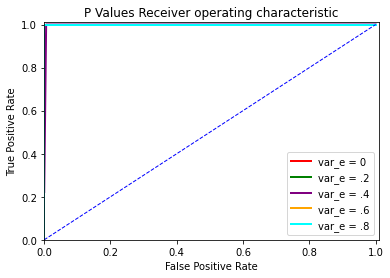

In [13]:
plt.figure()

# Roc Curve:
plt.plot(FPR_List_Total[0], TPR_List_Total[0], color='red', lw=2,
         label='var_e = 0')
plt.plot(FPR_List_Total[1], TPR_List_Total[1], color='green', lw=2,
         label='var_e = .2')
plt.plot(FPR_List_Total[2], TPR_List_Total[2], color='purple', lw=2,
         label='var_e = .4')
plt.plot(FPR_List_Total[3], TPR_List_Total[3], color='orange', lw=2, 
         label='var_e = .6')
plt.plot(FPR_List_Total[4], TPR_List_Total[4], color='cyan', lw=2,
         label='var_e = .8')
# Random Guess line:
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

# Defining The Range of X-Axis and Y-Axis:
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])

# Labels, Title, Legend:
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('P Values Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('No_SHAP_ROC_Multiple_1000')

plt.show()